In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMClassifier
from tqdm import tqdm
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.neural_network import MLPClassifier

In [3]:
df = pd.read_csv('Crop_recommendation.csv')

In [4]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [5]:
x = df.drop(['label'], axis=1)
x.head()

,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340


In [6]:
Y = df['label']
encode = preprocessing.LabelEncoder()
y = encode.fit_transform(Y)
print("Label length: ",len(y))

Label length:  2200


In [7]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42)
print(len(x_train),len(y_train),len(x_test),len(y_test))

1760 1760 440 440


In [18]:
a={'decision tree 2': {
    'model': DecisionTreeClassifier(),
    'params': {
        'decisiontreeclassifier__criterion': ['gini'],
        'decisiontreeclassifier__splitter': ['best'],
        'decisiontreeclassifier__max_depth': [None],
        'decisiontreeclassifier__min_samples_split': [2],
        'decisiontreeclassifier__min_samples_leaf': [1],
        'decisiontreeclassifier__max_features': [None],
        'decisiontreeclassifier__max_leaf_nodes': [None],
        'decisiontreeclassifier__min_impurity_decrease': [0.0]
    }
},
    
    
    'decision tree' : {
        'model' : DecisionTreeClassifier(criterion='gini'),
        'params':{'decisiontreeclassifier__splitter':['best','random']}
    },

   

   # temp
   #  # 'svm': {
   #  #     'model': SVC(gamma='auto',probability=True),
   #  #     'params' : {
   #  #         'svc__C': [1,10,100,1000],
   #  #         'svc__kernel': ['rbf','linear']
   #  #     }  
   #  # },
   
    'svm 2': {
    'model': SVC(probability=True),
    'params': {
        'svc__C': [100],
        'svc__kernel': ['rbf'],
        'svc__shrinking': [True],
        'svc__class_weight': [None]
    }
},
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
'random_forest2': {
        'model': RandomForestClassifier(),
        'params': {'randomforestclassifier__n_estimators': [10],
                   'randomforestclassifier__max_depth': [30],
                   'randomforestclassifier__min_samples_split': [10],
                   'randomforestclassifier__min_samples_leaf': [1]}
    },
    'k classifier': {
       'model':KNeighborsClassifier(),
       'params':{'kneighborsclassifier__n_neighbors':[5,10,20,25],'kneighborsclassifier__weights':['uniform','distance']}
    },

   
   'k classifier 2': {
   'model': KNeighborsClassifier(),
   'params': {
       'kneighborsclassifier__n_neighbors': [5],
       'kneighborsclassifier__weights': ['distance'],
       'kneighborsclassifier__algorithm': ['auto'],
       'kneighborsclassifier__p': [1],
       'kneighborsclassifier__metric': ['manhattan']
   }
},

    'gradient_boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'gradientboostingclassifier__n_estimators': [50, 100, 200],
            'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2],
            'gradientboostingclassifier__max_depth': [3, 5, 7]
        }
    },

    # 'lgbm_classifier': {
    #    'model': LGBMClassifier(),
    #    'params': {
    #        'lgbmclassifier__n_estimators': [50, 100, 200],
    #        'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1]
    #     }
    # },

   
   'gaussian_naive_bayes': {
       'model': GaussianNB(),
       'params': {
           'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)
        }
    },
   
   'mlp_classifier': {
    'model': MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, validation_fraction=0.1),
    'params': {
        'mlpclassifier__hidden_layer_sizes': [(50, 50)],
        'mlpclassifier__activation': ['relu'],
        'mlpclassifier__max_iter': [500],
        'mlpclassifier__solver': ['adam'],
        'mlpclassifier__alpha': [0.0001],
        'mlpclassifier__learning_rate': ['constant'],
        'mlpclassifier__learning_rate_init': [0.01]
    }
  }

}

In [19]:
score = []
details = []
best_param = {}

for mdl, par in tqdm(a.items(), desc="Training Models"):
    start_time = time.time()
    pipe = make_pipeline(preprocessing.StandardScaler(), par['model'])
    res = model_selection.GridSearchCV(pipe, par['params'], cv=20, verbose=False)
    res.fit(x_train, y_train)
    
    score.append({
        'Model name': mdl,
        'Best score': res.best_score_,
        'Best param': res.best_params_,
        'Training Time': round(time.time() - start_time, 2)
    })
    
    details.append(pd.DataFrame(res.cv_results_))
    best_param[mdl] = res.best_estimator_

pd.DataFrame(score)


Training Models: 100%|███████████████████████| 10/10 [1:08:21<00:00, 410.14s/it]


,Model name,Best score,Best param,Training Time
0,decision tree 2,0.984659,"{'decisiontreeclassifier__criterion': 'gini', ...",0.21
1,decision tree,0.986932,{'decisiontreeclassifier__splitter': 'best'},0.27
2,svm 2,0.988636,"{'svc__C': 100, 'svc__class_weight': None, 'sv...",2.39
3,random_forest,0.992614,{'randomforestclassifier__n_estimators': 10},0.91
4,random_forest2,0.994886,"{'randomforestclassifier__max_depth': 30, 'ran...",0.51
5,k classifier,0.981250,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.90
6,k classifier 2,0.982955,"{'kneighborsclassifier__algorithm': 'auto', 'k...",0.10
7,gradient_boosting,0.991477,{'gradientboostingclassifier__learning_rate': ...,4083.99
8,gaussian_naive_bayes,0.994318,{'gaussiannb__var_smoothing': 0.00351119173421...,7.97
9,mlp_classifier,0.982386,"{'mlpclassifier__activation': 'relu', 'mlpclas...",4.17


In [20]:
score

[{'Model name': 'decision tree 2',
  'Best score': 0.9846590909090909,
  'Best param': {'decisiontreeclassifier__criterion': 'gini',
   'decisiontreeclassifier__max_depth': None,
   'decisiontreeclassifier__max_features': None,
   'decisiontreeclassifier__max_leaf_nodes': None,
   'decisiontreeclassifier__min_impurity_decrease': 0.0,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2,
   'decisiontreeclassifier__splitter': 'best'},
  'Training Time': 0.21},
 {'Model name': 'decision tree',
  'Best score': 0.9869318181818182,
  'Best param': {'decisiontreeclassifier__splitter': 'best'},
  'Training Time': 0.27},
 {'Model name': 'svm 2',
  'Best score': 0.9886363636363636,
  'Best param': {'svc__C': 100,
   'svc__class_weight': None,
   'svc__kernel': 'rbf',
   'svc__shrinking': True},
  'Training Time': 2.39},
 {'Model name': 'random_forest',
  'Best score': 0.9926136363636363,
  'Best param': {'randomforestclassifier__n_estimators': 10},

In [21]:
pd.DataFrame(score)

,Model name,Best score,Best param,Training Time
0,decision tree 2,0.984659,"{'decisiontreeclassifier__criterion': 'gini', ...",0.21
1,decision tree,0.986932,{'decisiontreeclassifier__splitter': 'best'},0.27
2,svm 2,0.988636,"{'svc__C': 100, 'svc__class_weight': None, 'sv...",2.39
3,random_forest,0.992614,{'randomforestclassifier__n_estimators': 10},0.91
4,random_forest2,0.994886,"{'randomforestclassifier__max_depth': 30, 'ran...",0.51
5,k classifier,0.981250,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.90
6,k classifier 2,0.982955,"{'kneighborsclassifier__algorithm': 'auto', 'k...",0.10
7,gradient_boosting,0.991477,{'gradientboostingclassifier__learning_rate': ...,4083.99
8,gaussian_naive_bayes,0.994318,{'gaussiannb__var_smoothing': 0.00351119173421...,7.97
9,mlp_classifier,0.982386,"{'mlpclassifier__activation': 'relu', 'mlpclas...",4.17


In [22]:
# This is for test set testing


for i in best_param.keys():
    print(f'{i} : {best_param[i].score(x_test, y_test)}')

decision tree 2 : 0.9840909090909091
decision tree : 0.9840909090909091
svm 2 : 0.975
random_forest : 0.9818181818181818
random_forest2 : 0.990909090909091
k classifier : 0.9681818181818181
k classifier 2 : 0.9772727272727273
gradient_boosting : 0.9863636363636363
gaussian_naive_bayes : 0.9931818181818182
mlp_classifier : 0.9681818181818181


In [23]:
predicted1 = best_param['decision tree 2'].predict(x_test)
predicted1

array([15, 21, 17, 17,  0, 12,  0, 13, 14, 10,  2,  4, 19,  8,  4, 19,  0,
       11, 17, 15,  5, 17, 16, 17,  3,  8, 14, 16, 18, 20, 19, 13,  8, 10,
        8,  2,  8,  3,  3,  9, 17, 12,  2, 11, 14, 11, 18,  4, 15, 11,  2,
        5,  7, 14,  5,  9,  6,  0,  1,  2, 21,  4, 10, 16, 17, 18, 16, 20,
       15, 18, 15,  4,  8,  1,  2, 17,  1,  6, 21, 16,  5,  3, 20, 13, 16,
       12,  5, 13,  2, 19, 11, 13,  6, 17, 18, 13,  9,  5,  2, 10,  4, 20,
       16, 15, 21,  9, 21,  1, 18, 13,  1,  8,  6, 19, 18,  3, 11,  4, 19,
       20, 18,  7,  2,  4,  3,  2,  4, 11,  1, 13,  1,  9, 19,  3,  4, 16,
       18,  1,  1,  0,  9, 15, 14, 13,  4, 11,  0,  4,  9,  2, 14, 10, 21,
       14, 18, 18, 18,  9, 11,  8,  3,  0, 16,  6, 20,  4,  7, 10, 21,  7,
        7,  2, 19,  3,  4, 11, 10,  7, 21,  8,  5,  5,  9,  8, 13,  9,  1,
        9,  4, 17, 17, 14, 12, 19, 21,  9, 11,  0,  2,  3,  7,  7,  1,  6,
       20, 19, 14,  1,  8, 14, 11,  3,  3,  3,  0, 20,  9, 17,  5,  2,  9,
       12, 12,  4, 17,  0

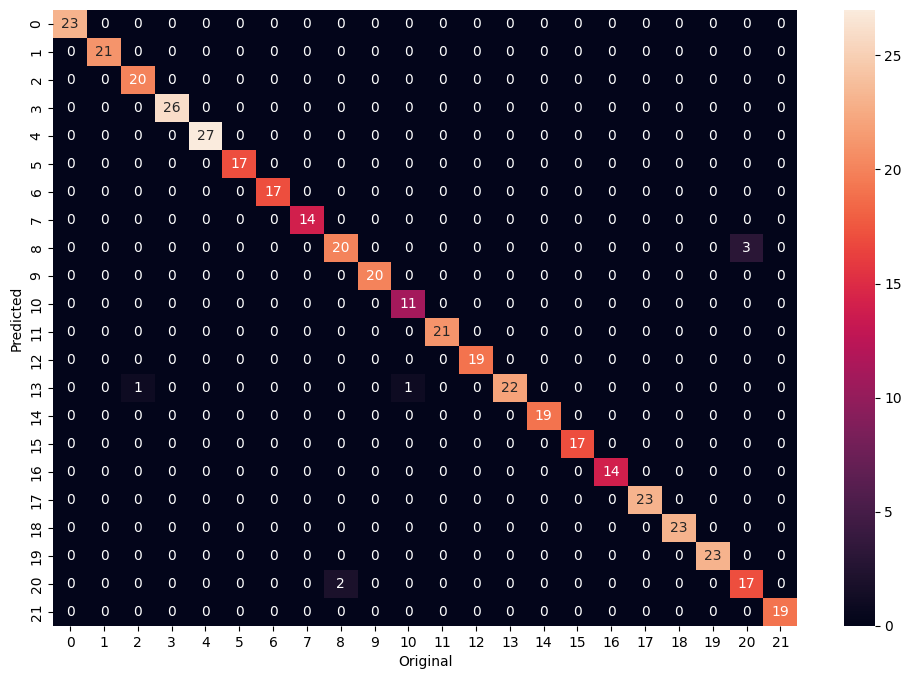

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test,predicted1),annot=True)
plt.xlabel("Original")
plt.ylabel("Predicted")
plt.show()

In [25]:
predicted2 = best_param['gaussian_naive_bayes'].predict(x_test)
predicted2

array([15, 21, 17, 17,  0, 12,  0, 13, 14, 10,  2,  4, 19,  8,  4, 19,  0,
       11, 17, 15,  5, 17, 16, 17,  3,  8, 14, 16, 18, 20, 19, 13,  8, 10,
        8,  2,  8,  3,  3,  9, 17, 12,  2, 11, 14, 11, 18,  4, 15, 11,  2,
        5,  7, 14,  5,  9,  6,  0,  1,  2, 21,  4, 10, 16, 17, 18, 16, 20,
       15, 18, 15,  4,  8,  1,  2, 17,  1,  6, 21, 16,  5,  3, 20, 13, 16,
       12,  5, 13,  2, 19, 11, 13,  6, 17, 18, 13,  9,  5,  2, 10,  4, 20,
       16, 15, 21,  9, 21,  1, 18, 13,  1,  8,  6, 19, 18,  3, 11,  4, 19,
       20, 18,  7,  2,  4,  3,  2,  4, 11,  1, 13,  1,  9, 19,  3,  4, 16,
       18,  1,  1,  0,  9, 15, 14, 13,  4, 11,  0,  4,  9, 13, 14, 10, 21,
       14, 18, 18, 18,  9, 11,  8,  3,  0, 16,  6, 20,  4,  7, 10, 21,  7,
        7,  2, 19,  3,  4, 11, 10,  7, 21,  8,  5,  5,  9,  8, 13,  9,  1,
        9,  4, 17, 17, 14, 12, 19, 21,  9, 11,  0,  2,  3,  7,  7,  1,  6,
       20, 19, 14,  1,  8, 14, 11,  3,  3,  3,  0, 20,  9, 17,  5,  2,  9,
       12, 12,  4, 17,  0

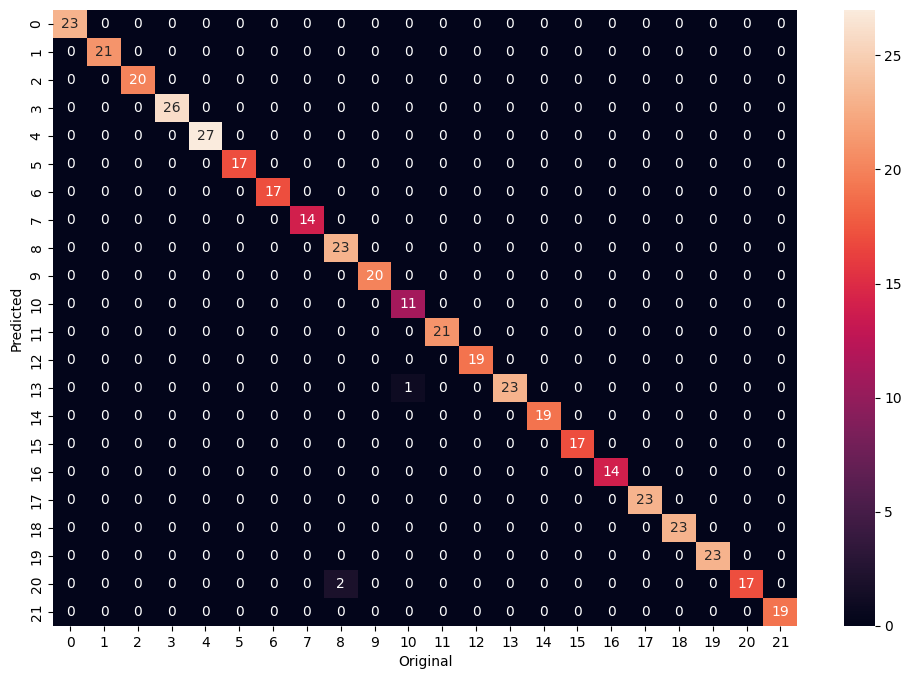

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test,predicted2),annot=True)
plt.xlabel("Original")
plt.ylabel("Predicted")
plt.show()

In [27]:
predicted = best_param['gaussian_naive_bayes'].predict(x_test)
predicted

array([15, 21, 17, 17,  0, 12,  0, 13, 14, 10,  2,  4, 19,  8,  4, 19,  0,
       11, 17, 15,  5, 17, 16, 17,  3,  8, 14, 16, 18, 20, 19, 13,  8, 10,
        8,  2,  8,  3,  3,  9, 17, 12,  2, 11, 14, 11, 18,  4, 15, 11,  2,
        5,  7, 14,  5,  9,  6,  0,  1,  2, 21,  4, 10, 16, 17, 18, 16, 20,
       15, 18, 15,  4,  8,  1,  2, 17,  1,  6, 21, 16,  5,  3, 20, 13, 16,
       12,  5, 13,  2, 19, 11, 13,  6, 17, 18, 13,  9,  5,  2, 10,  4, 20,
       16, 15, 21,  9, 21,  1, 18, 13,  1,  8,  6, 19, 18,  3, 11,  4, 19,
       20, 18,  7,  2,  4,  3,  2,  4, 11,  1, 13,  1,  9, 19,  3,  4, 16,
       18,  1,  1,  0,  9, 15, 14, 13,  4, 11,  0,  4,  9, 13, 14, 10, 21,
       14, 18, 18, 18,  9, 11,  8,  3,  0, 16,  6, 20,  4,  7, 10, 21,  7,
        7,  2, 19,  3,  4, 11, 10,  7, 21,  8,  5,  5,  9,  8, 13,  9,  1,
        9,  4, 17, 17, 14, 12, 19, 21,  9, 11,  0,  2,  3,  7,  7,  1,  6,
       20, 19, 14,  1,  8, 14, 11,  3,  3,  3,  0, 20,  9, 17,  5,  2,  9,
       12, 12,  4, 17,  0

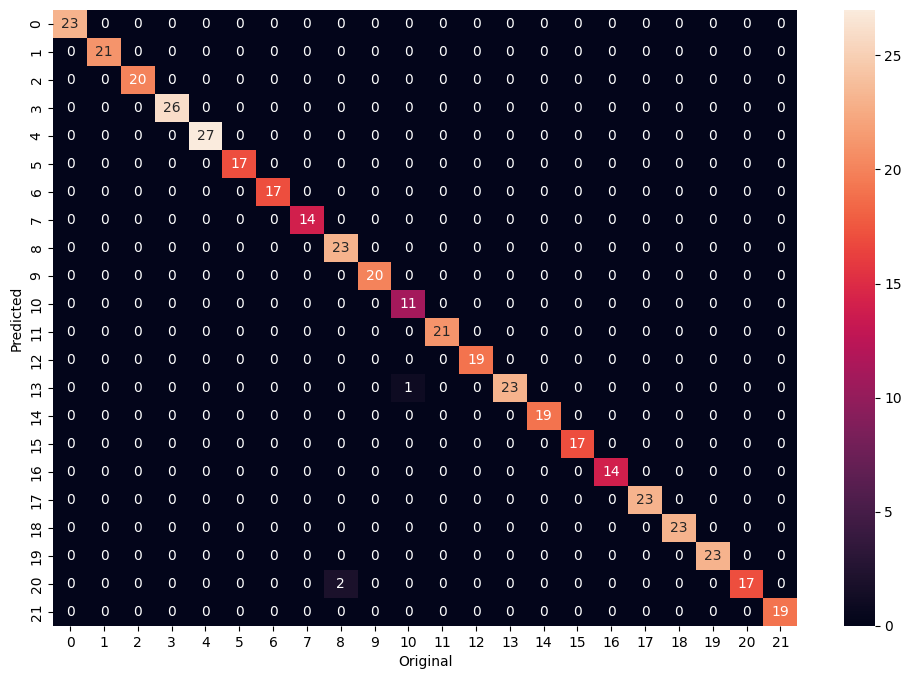

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test,predicted),annot=True)
plt.xlabel("Original")
plt.ylabel("Predicted")
plt.show()

In [57]:
bagging_classifiers = {}

for model_name, model_params in a.items():
    model = model_params['model']
    params = model_params['params']
    
    # Create a pipeline with preprocessing and the model
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    
    # Create a Bagging Classifier with the pipeline as the base estimator
    bagging_model = BaggingClassifier(estimator=pipe, n_estimators=100, oob_score=True, random_state=42, max_samples=0.8)
    
    # Store the Bagging Classifier in the dictionary
    bagging_classifiers[model_name] = bagging_model


In [58]:
# var_smoothing_value = 0.001873817422860383

# pipe1 = make_pipeline(preprocessing.StandardScaler(), GaussianNB(var_smoothing=var_smoothing_value))
# bag_model = BaggingClassifier(estimator=pipe1, n_estimators=100,
#                               oob_score=True, random_state=0, max_samples=0.8)

In [59]:
# bagging_model.fit(x_train,y_train)

# Train each bagging classifier
for model_name, bagging_model in bagging_classifiers.items():
    bagging_model.fit(x_train, y_train)


In [60]:
# bagging_model.score(x_test,y_test)

from sklearn.metrics import classification_report

# Evaluate each bagging classifier
for model_name, bagging_model in bagging_classifiers.items():
    y_pred = bagging_model.predict(x_test)
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))


Model: decision tree 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      0.96      0.94        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        14
    

In [61]:
predict = bagging_model.predict(x_test)

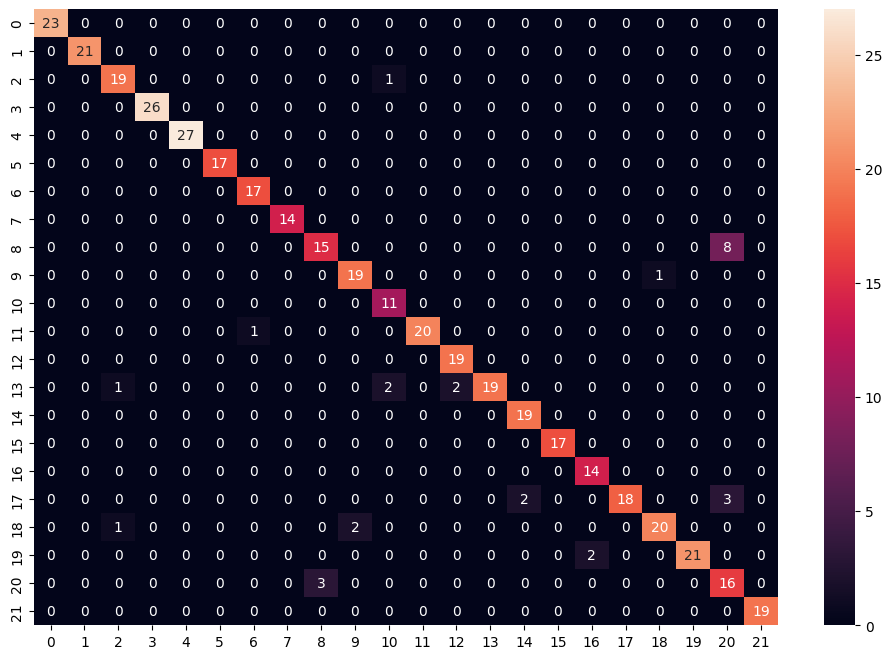

In [62]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test,predict),annot=True)
plt.show()

In [72]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to store evaluation metrics
classifier_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Evaluate each bagging classifier
for model_name, bagging_model in bagging_classifiers.items():
    y_pred = bagging_model.predict(x_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Append results to lists
    classifier_names.append(model_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Create DataFrame
results_df = pd.DataFrame({
    'Classifier': classifier_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
})

# Display the DataFrame
print(results_df)


             Classifier  Accuracy  Precision    Recall  F1-score
0       decision tree 2  0.990909   0.991162  0.990909  0.990915
1         decision tree  0.990909   0.991162  0.990909  0.990915
2                 svm 2  0.977273   0.979770  0.977273  0.977420
3         random_forest  0.993182   0.993735  0.993182  0.993175
4        random_forest2  0.993182   0.993735  0.993182  0.993175
5          k classifier  0.963636   0.969043  0.963636  0.963429
6        k classifier 2  0.963636   0.969043  0.963636  0.963429
7     gradient_boosting  0.984091   0.985607  0.984091  0.984046
8  gaussian_naive_bayes  0.995455   0.995818  0.995455  0.995423
9        mlp_classifier  0.934091   0.942842  0.934091  0.934629


In [73]:
# dha2 =pd.DataFrame(Y)
# code = pd.DataFrame(dha2['label'].unique())

In [74]:
# dha = pd.DataFrame(y)
# encode = pd.DataFrame(dha[0].unique())
# refer = pd.DataFrame()
# refer['code']=code
# refer['encode']=encode
# refer

In [75]:
# print(classification_report(y_test,predict))